<a href="https://colab.research.google.com/github/asgutierrt/Introduction_to_IA/blob/main/unsupervised/no_supervisado_dev.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# run ONCE (only in Colab)
#!git clone https://github.com/asgutierrt/Introduction_to_IA.git
#curr_path="/content/Introduction_to_IA/unsupervised/src"

In [3]:
from pathlib import Path
import os
import plotly.io as pio
import numpy as np
import umap
from os.path import join

# to import from src folder
try:
    os.chdir(curr_path)
    # custom visualization: colab only
    pio.renderers.default='colab'
except:
    os.chdir(os.path.join(Path().absolute().parent,'src'))
    pio.renderers.default='vscode' # other renderers: 'browser', 'jupyterlab', 'notebook'


%load_ext autoreload
%autoreload 2

from modules.load_data import load_data
from modules.autoencoder import encode
from modules.distances import plot_distances, get_distance_matrix, covarianza_inversa, calculate_norms
from modules.cluster_algorithms import naive_boxes, ClusterProblem, density_substraction, naive_kn
from modules.support_functions import encode_array, make_grid
from modules.visualizations import df_plot_PairGrid, plot_clusters

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


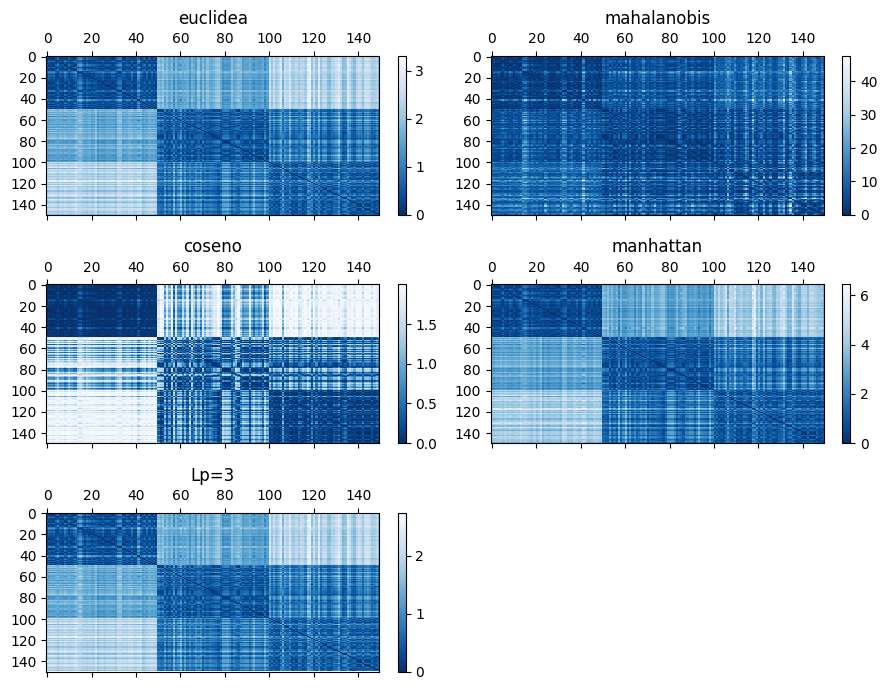

In [4]:
# 1. set working directory and paths
figs_path= os.path.join('..','notebooks','dev_reports','figures')
results_path= os.path.join('..','notebooks','dev_reports','group_matrix')
filename = 'water_potability.txt'
filename='iris'

# 2. load and process data
X_original = load_data(os.path.join('..','data',filename),verbose=False)
#X_expanded = encode(X_original, encoding_layers_dims=[int(X.shape[1]*1.2),int(X.shape[1]*1.5)], verbose=False)
X_embeded = umap.UMAP().fit_transform(X_original)

X, X_name =X_original,'x_original'
#X, X_name =X_embeded,'x_embeded'

# 3. global setup for all clustering algorithms
normas=['euclidea','mahalanobis','coseno','manhattan','Lp=3']
plot_dims=list(range(min(3,X.shape[1]))) # dimensions to plot

# distance matrix
cov_i = covarianza_inversa(X)
D_XToX = get_distance_matrix(X,X,cov_i,norms=normas)
plot_distances(D_XToX,normas,join(figs_path,'distances_%s.png'%X_name))

# cluster problem object
cluster_setup=ClusterProblem(X_name,normas,results_path,figs_path)

c:\Users\anita\.conda\envs\ia_env\lib\site-packages\seaborn\distributions.py:160: UserWarning:

The label '_nolegend_' of <matplotlib.lines.Line2D object at 0x00000191CCFD8D00> starts with '_'. It is thus excluded from the legend.

c:\Users\anita\.conda\envs\ia_env\lib\site-packages\seaborn\distributions.py:160: UserWarning:

The label '_nolegend_' of <matplotlib.lines.Line2D object at 0x00000191CCFF7580> starts with '_'. It is thus excluded from the legend.

c:\Users\anita\.conda\envs\ia_env\lib\site-packages\seaborn\distributions.py:160: UserWarning:

The label '_nolegend_' of <matplotlib.lines.Line2D object at 0x00000191CCFF7AC0> starts with '_'. It is thus excluded from the legend.

c:\Users\anita\.conda\envs\ia_env\lib\site-packages\seaborn\distributions.py:160: UserWarning:

The label '_nolegend_' of <matplotlib.lines.Line2D object at 0x00000191CD029FA0> starts with '_'. It is thus excluded from the legend.



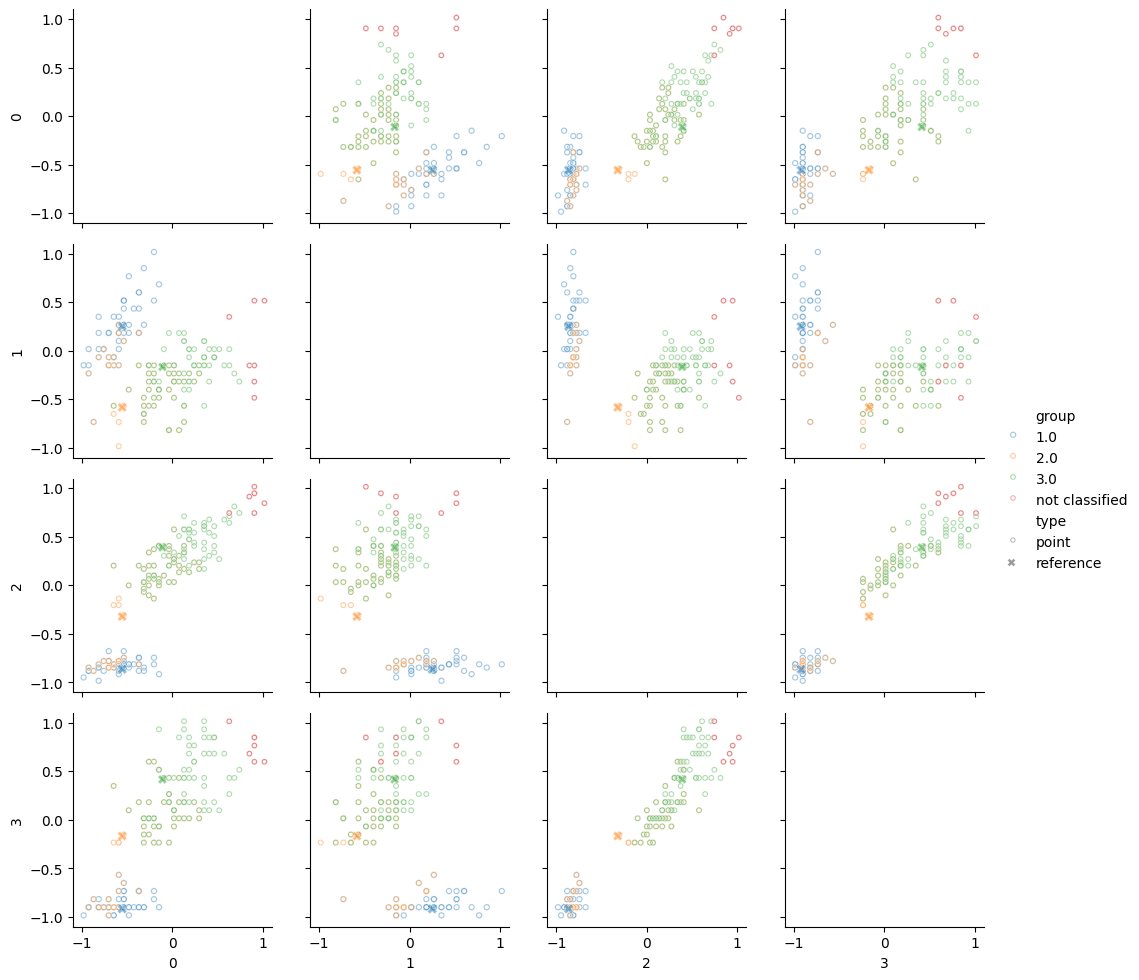

In [12]:
# 1. naive clustering: cajitas
n_groups=3
G, G_ref_points=cluster_setup.do_ClusterPipeline(X, D_XToX, naive_boxes, 'naive_boxes', n_groupps=n_groups)

i=0
fig=plot_clusters(i,X,G,G_ref_points,grid=None)

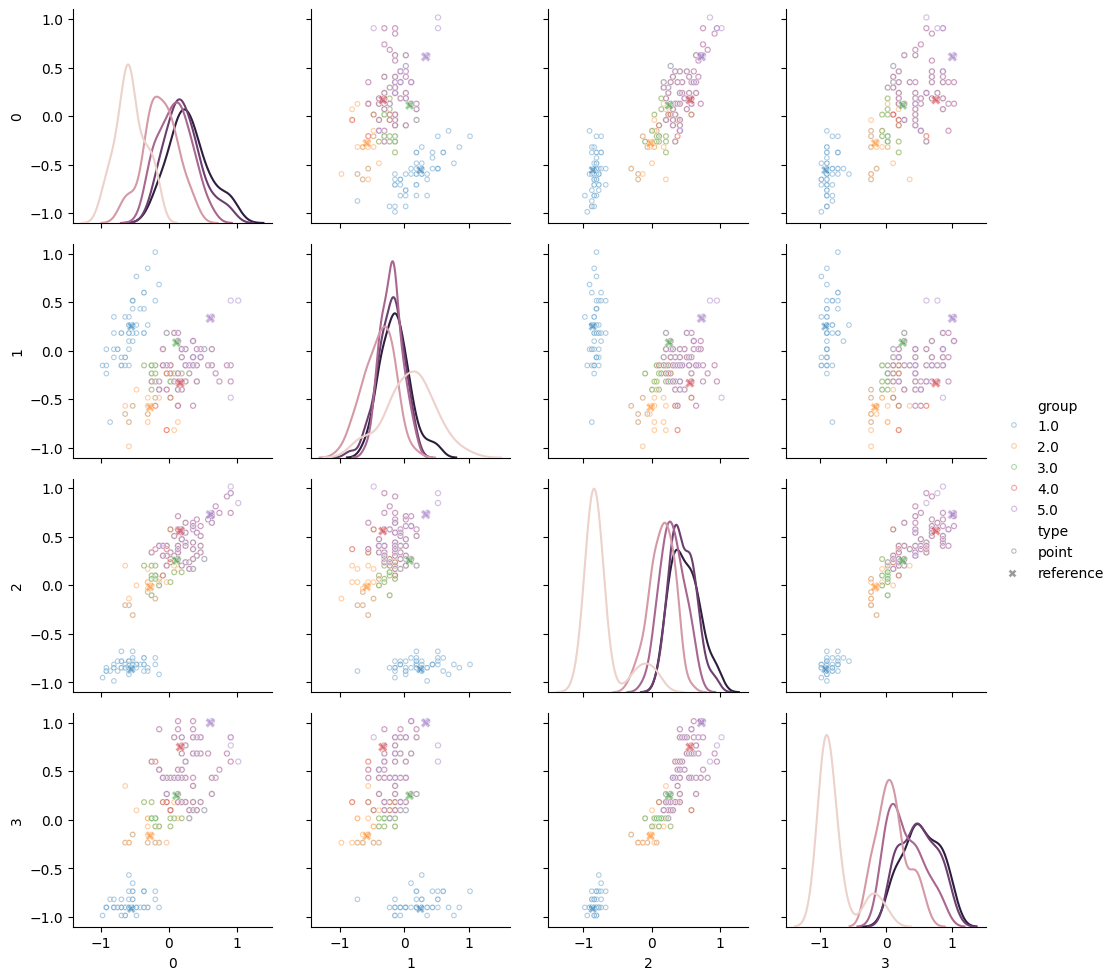

In [14]:
# 1. naive clustering: k vecinos
k_n=60
G, G_ref_points = cluster_setup.do_ClusterPipeline(X, D_XToX, naive_kn, 'naive_kn', k_n=k_n)

i=0
fig=plot_clusters(i,X,G,G_ref_points,grid=None)

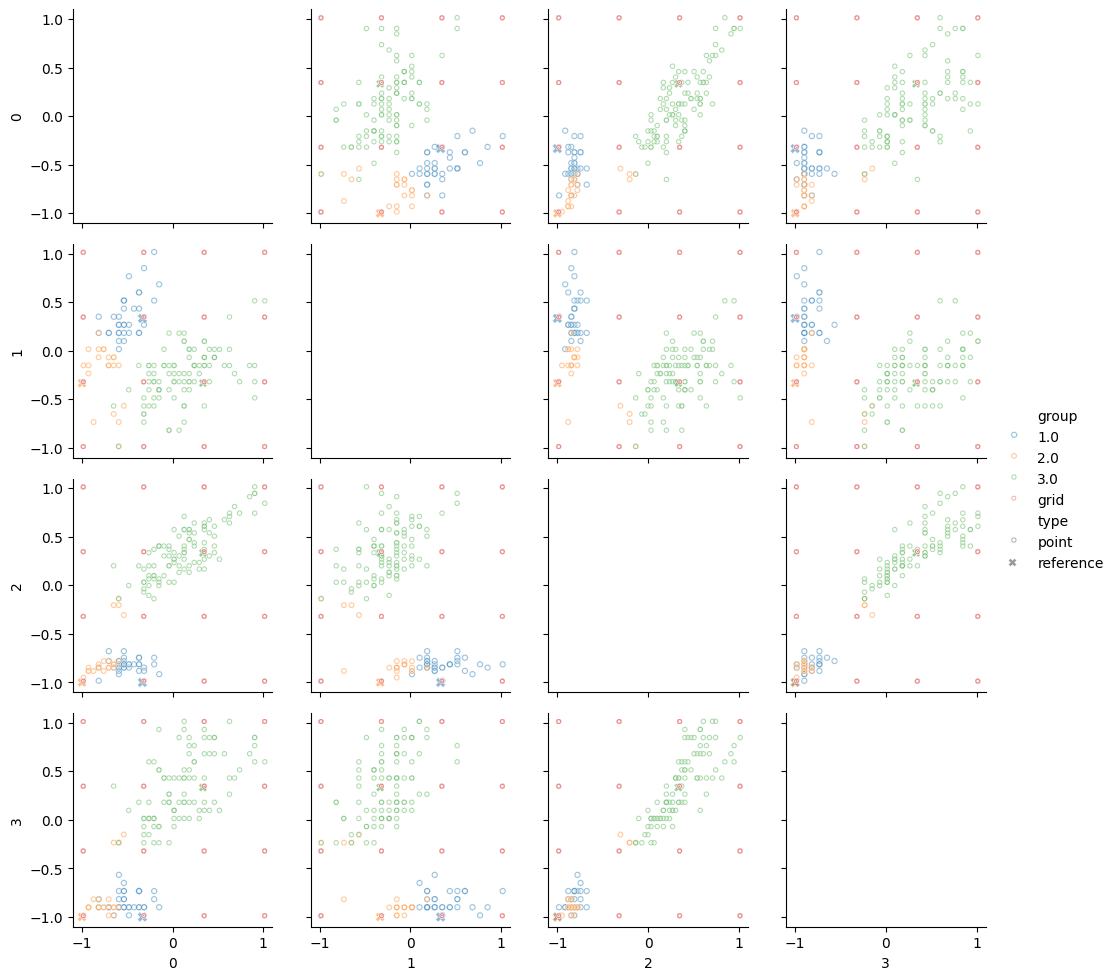

In [21]:
# 3. mountain clustering (with grid data)
grid = make_grid(X,n_intervals=3)
D_GridToX = get_distance_matrix(grid,X,cov_i,norms=normas)
D_GridToGrid = get_distance_matrix(grid,grid,covarianza_inversa(grid),norms=normas)

ra=0.3
stop_criteria='k_centroids' # or 'low_density' and epsilon [=0.2] argument
k=3            
G, G_ref_points=cluster_setup.do_ClusterPipeline(X, zip(D_GridToX,D_GridToGrid), density_substraction, 'mountain_alg', 
                                                ra=ra,kind='mountain',stop_criteria=stop_criteria,k=k)
i=0
fig=plot_clusters(i,X,G,G_ref_points,grid=grid)

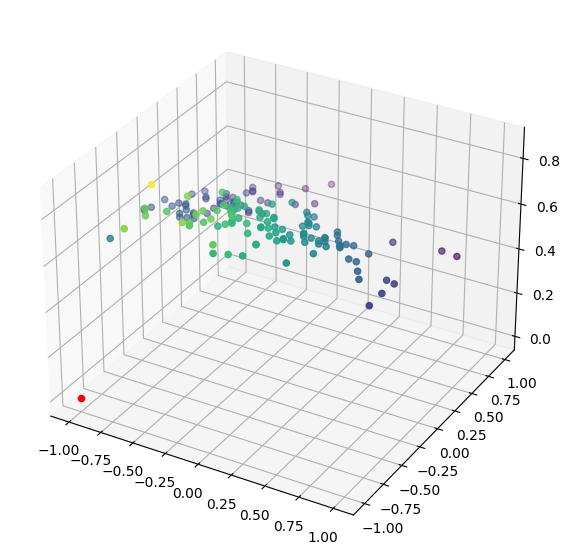

In [297]:
import matplotlib.pyplot as plt

# visualize density
radius=lambda r: 1/(4*r**2)
ra=1
a=np.apply_along_axis(lambda x: np.exp(-radius(ra) * x), 0, D_GridToX[0])


x=10
fig = plt.figure(figsize = (10, 7))
ax = plt.axes(projection ="3d")
ax.scatter3D(X[:,0],X[:,1],a[x],c=a[x])
ax.scatter3D(grid[x,0],grid[x,1],[0],c='red')

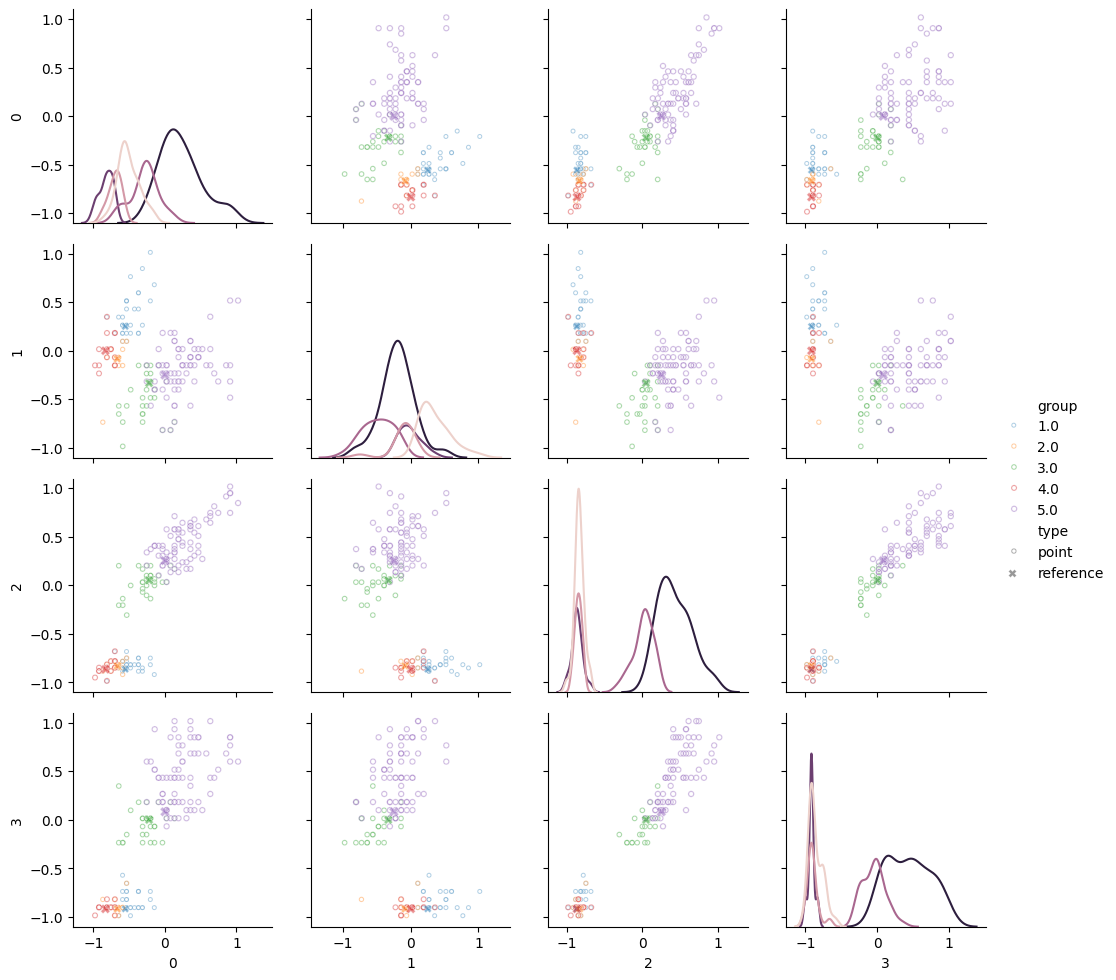

In [20]:
# 4. substractive clustering
ra=0.3
stop_criteria='k_centroids' # or 'low_density' and epsilon [=0.2] argument
k=5         
G, G_ref_points=cluster_setup.do_ClusterPipeline(X, D_XToX**2, density_substraction, 'substractive_alg', 
                                                ra=ra,kind='substractive',stop_criteria=stop_criteria,k=k)
i=0
fig=plot_clusters(i,X,G,G_ref_points,grid=None)

In [17]:
import plotly.graph_objects as go

norma_i=0

fig = go.Figure()

fig.add_scatter3d(x=X[:,0], y=X[:,1], z=X[:,2],
                  mode='markers',
                  marker=dict(size=5,color='mediumblue'), name='data points')

fig.add_scatter3d(x=grid[:,0], y=grid[:,1], z=grid[:,2],
                  mode='markers', marker=dict(size=5, color='purple'), name='grid points')

# tight layout
fig.update_layout(title_text='naive classes with norm %s: ir cambiando el punto de referencia'%normas[norma_i], 
                  showlegend=False, margin=dict(l=0, r=0, t=40, b=0))
fig.show()

In [ ]:
# readme, requirements.txt: funcionalidad de todo: main (entradas al sistema: archivo de datos), funciones en carpeta src,
# path automatico
# ejm. santiago hincapie, alejandro murillo
# documentar cada funcion y el codigo

In [ ]:
# 5 tipos de clustering en Rn con iris dataset
# 1. leer el archivo: preguntar tipo de archivo (csv,txt,json,xlsx,xls), almacenarlo.
# 1.a. variables categoricas a numericas: crear columnas binarias - onehot encoding
# 2. clustering: matrices de distancias, cajas y k=ki vecinos
# 2.a. n_conjuntos: depende de la segmentacion, parametro default k
# 2.output. matriz Nxki con {0,1}
# - cuenta de a cuales grupos perteneces


In [ ]:
# densidad
# definir la forma del cluster
# subconjunto:
